# Are unannotated transcripts supported by long reads?

In [1]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import font_manager
import matplotlib as mpl
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
combined_df = pd.read_csv( '../data_processed/curated_HIT.tsv', sep='\t')

/tmp/19452335/ipykernel_2734232/558083981.py:1: DtypeWarning: Columns (3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_df = pd.read_csv( '../data_processed/curated_HIT.tsv', sep='\t')


In [3]:
combined_df["summarized_category"].unique()

array(['GENCODE-annotated transcripts',
       'Unannotated transcripts with all exons annotated',
       'Unannotated transcripts with annotated and unannotated exons',
       'Unannotated transcripts without any annotated exons'],
      dtype=object)

In [4]:
def split_attributes(df, *attribute_type):
    """split attribute of a gtf into separate columns"""
    try: 
        l_attributes = df.strip(';').split('; ')
        attribute_position = [i for i, x in enumerate(l_attributes) if x.startswith(attribute_type)]
        attribute = l_attributes[attribute_position[0]].split(' ')[1].strip('"')
        return attribute
    except Exception:
        return np.nan

In [5]:
# Load gtf of all tx
gtf_column_names = ['chromosome','source','feature','start','end','score','strand','frame','attribute']
gtf_df = pd.read_csv( '../data_processed/curated_HIT.gtf',sep='\t', header=None, names=gtf_column_names)
gtf_df.loc[:, 'transcript_id'] = gtf_df['attribute'].apply(split_attributes, args=("transcript_id",))
gtf_df.head()

,chromosome,source,feature,start,end,score,strand,frame,attribute,transcript_id
0,chr1,custom,exon,61077274,61077628,.,+,.,"gene_id ""ENSG00000162599""; transcript_id ""ENCT...",ENCT00000006334.1
1,chr1,custom,exon,61077916,61079203,.,+,.,"gene_id ""ENSG00000162599""; transcript_id ""ENCT...",ENCT00000006334.1
2,chr1,custom,exon,160261734,160261922,.,+,.,"gene_id ""ENSG00000228606""; transcript_id ""ENCT...",ENCT00000013056.1
3,chr1,custom,exon,160281430,160281892,.,+,.,"gene_id ""ENSG00000228606""; transcript_id ""ENCT...",ENCT00000013056.1
4,chr1,custom,exon,239386568,239387227,.,+,.,"gene_id ""ENSG00000133019""; transcript_id ""ENCT...",ENCT00000019620.1


## HIT vs PacBio

In [6]:
# All unannotated & annotated transcripts from HIT
gencode_unannotated = combined_df[combined_df['summarized_category'] != "GENCODE-annotated transcripts"]
gencode_annotated = combined_df[combined_df['summarized_category'] == "GENCODE-annotated transcripts"]

In [7]:
# number of annotated & unannotated transcripts
num_unannotated = len(gencode_unannotated)
num_annotated = len(gencode_annotated)
print('{} unannotated transcripts'.format(num_unannotated))
print('{} annotated transcripts'.format(num_annotated))

337452 unannotated transcripts
38890 annotated transcripts


In [8]:
# create a list for the plot
annotation = [num_annotated, num_unannotated]
annotation

[38890, 337452]

In [9]:
# Make HIT gtf of the unannotated transcripts
unannotated_hit = gtf_df[gtf_df['transcript_id'].isin(gencode_unannotated['transcript_id'])].copy()
unannotated_hit.drop('transcript_id', axis=1, inplace=True)

In [10]:
# save gtf with unannotated transcripts
unannotated_hit.to_csv('../data_processed/hit_vs_pacbio_fantom/unannotated_hit.gtf', sep='\t', header=False, index=False, quoting=csv.QUOTE_NONE)

gffcompare -r ../data_processed/hit_vs_pacbio_fantom/CrossMap_PacBio_reads.gff \
-o ../data_processed/hit_vs_pacbio_fantom/unannotated_hit_vs_pacbio \
../data_processed/hit_vs_pacbio_fantom/unannotated_hit.gtf

In [10]:
# load output file from gffcompare
unannotated_pacbio = pd.read_csv('../data_processed/hit_vs_pacbio_fantom/unannotated_hit_vs_PacBio.annotated.gtf',
                                 sep='\t', header=None, names=gtf_column_names)

In [11]:
# keep only transcripts
unannotated_pacbio = unannotated_pacbio[unannotated_pacbio['feature'] == 'transcript']
# split attributes
unannotated_pacbio['transcript_id'] = unannotated_pacbio['attribute'].apply(split_attributes, args=("transcript_id",))
unannotated_pacbio['class_code'] = unannotated_pacbio['attribute'].apply(split_attributes, args=('class_code',))

In [12]:
# number of unannotated transcripts detected by pacbio
unannotated_pacbio_detected = len(unannotated_pacbio[unannotated_pacbio['class_code'] == '='])
unannotated_pacbio_detected

66778

gffcompare -r ../data_processed/hit_vs_pacbio_fantom/CrossMap_PacBio_reads.gff \
-o ../data_processed/hit_vs_pacbio_fantom/hit_vs_PacBio \
../data_processed/curated_HIT.gtf

In [13]:
full_pacbio = pd.read_csv('../data_processed/hit_vs_pacbio_fantom/hit_vs_PacBio.annotated.gtf',
                                 sep='\t', header=None, names=gtf_column_names)

In [14]:
# keep only transcripts
full_pacbio = full_pacbio[full_pacbio['feature'] == 'transcript']
# split attributes
full_pacbio['transcript_id'] = full_pacbio['attribute'].apply(split_attributes, args=("transcript_id",))
full_pacbio['class_code'] = full_pacbio['attribute'].apply(split_attributes, args=('class_code',))

In [15]:
full_pacbio_detected = len(full_pacbio[full_pacbio['class_code'] == '='])
full_pacbio_detected

76951

In [16]:
# number of transcripts annotated by PacBio
Unannotated_tx_w_pacbio = unannotated_pacbio_detected
Unannotated_tx_wo_pacbio = num_unannotated - unannotated_pacbio_detected
Annotated_tx_w_pacbio = full_pacbio_detected - unannotated_pacbio_detected
Annotated_tx_wo_pacbio = num_annotated - Annotated_tx_w_pacbio

In [17]:
# list for the plot
pacbio = [Annotated_tx_w_pacbio, Annotated_tx_wo_pacbio, Unannotated_tx_wo_pacbio, Unannotated_tx_w_pacbio]
pacbio

[10173, 28717, 270674, 66778]

In [18]:
font_path = "../data_raw/fonts/LatinmodernmathRegular.otf"  
font_manager.fontManager.addfont(font_path)

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
font = {'family' : 'Latin Modern Math',
       'weight' : 'normal',
       'size'   : 12}
mpl.rc('font', **font)

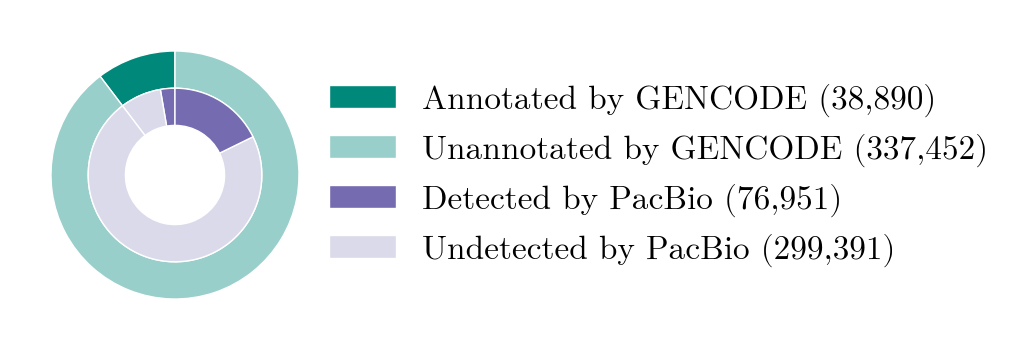

In [23]:
fig_pacbio, ax = plt.subplots(figsize=(2,3))


cmap = plt.get_cmap("tab20c")
outer_colors = ['#00897B', '#00897B66']
inner_colors = cmap(np.array([12,15,15,12]))

patches_out, texts_out =ax.pie(annotation , radius=1, colors=outer_colors, counterclock=True, startangle=90,
      wedgeprops=dict(width=0.3, edgecolor='w'))

patches_in, texts_in = ax.pie(pacbio, radius=0.7, colors=inner_colors, counterclock=True, startangle=90,
                             wedgeprops=dict(width=0.3, edgecolor='w'))
for w in patches_out:
    w.set_linewidth(0.5)
for w in patches_in:
    w.set_linewidth(0.5)

# counts for legend
annotated_count = annotation[0]
unannotated_count = annotation[1]
detected_count = pacbio[0] + pacbio[3]
undetected_count = pacbio[1] + pacbio[2]

labels = [
    f"Annotated by GENCODE ({annotated_count:,})",
    f"Unannotated by GENCODE ({unannotated_count:,})",
    f"Detected by PacBio ({detected_count:,})",
    f"Undetected by PacBio ({undetected_count:,})"
]

patches = patches_out + patches_in[0:2]

ax.legend(
    patches,
    labels,
    frameon=False,
    loc='center left',
    bbox_to_anchor=(0.9, 0.5),
    fontsize=12
)

ax.set(aspect="equal")

fig_pacbio.savefig("figures/pacbio_pie.pdf", bbox_inches='tight', dpi=300)
plt.show()

In [27]:
# unannotaed tx supported by PacBio
Unannotated_tx_w_pacbio/num_unannotated * 100

19.788888493770965

In [26]:
# annotaed tx supported by PacBio
Annotated_tx_w_pacbio/num_annotated * 100

26.15839547441502

## HIT vs FANTOM CAT

gffcompare -r /no_backup/jferrer/jmidgley/gffcompare_HIT_vs_FANTOM/CrossMap_FANTOM_CAT.lv4_stringent.gtf -o /no_backup/jferrer/jmidgley/gffcompare_HIT_vs_FANTOM/jessies_hit/unannotated_hit_vs_FANTOM /no_backup/jferrer/jmidgley/gffcompare_HIT_vs_Pacbio/jessies_hit/unannotated_hit.gtf

In [37]:
unannotated_fantom = pd.read_csv('../data_processed/hit_vs_pacbio_fantom/unannotated_hit_vs_FANTOM.annotated.gtf',
                                 sep='\t', header=None, names=gtf_column_names)

In [38]:
# keep only transcripts
unannotated_fantom = unannotated_fantom[unannotated_fantom['feature'] == 'transcript']
# split attributes
unannotated_fantom['transcript_id'] = unannotated_fantom['attribute'].apply(split_attributes, args=("transcript_id",))
unannotated_fantom['class_code'] = unannotated_fantom['attribute'].apply(split_attributes, args=('class_code',))

In [39]:
# number of unannotated transcripts detected by fantom
unannotated_fantom_detected = len(unannotated_fantom[unannotated_fantom['class_code'] == '='])
unannotated_fantom_detected

50533

gffcompare -r ../data_processed/hit_vs_pacbio_fantom/CrossMap_FANTOM_CAT.lv4_stringent.gtf \
-o ../data_processed/hit_vs_pacbio_fantom/hit_vs_FANTOM \
../data_processed/curated_HIT.gtf

In [40]:
full_fantom = pd.read_csv('../data_processed/hit_vs_pacbio_fantom/hit_vs_FANTOM.annotated.gtf',
                                 sep='\t', header=None, names=gtf_column_names)

In [41]:
# keep only transcripts
full_fantom = full_fantom[full_fantom['feature'] == 'transcript']
# split attributes
full_fantom['transcript_id'] = full_fantom['attribute'].apply(split_attributes, args=("transcript_id",))
full_fantom['class_code'] = full_fantom['attribute'].apply(split_attributes, args=('class_code',))

In [42]:
full_fantom_detected = len(full_fantom[full_fantom['class_code'] == '='])
full_fantom_detected

85201

In [43]:
# number of transcripts annotated by FANTOM
Unannotated_tx_w_fantom = unannotated_fantom_detected
Unannotated_tx_wo_fantom = num_unannotated - unannotated_fantom_detected
Annotated_tx_w_fantom = full_fantom_detected - unannotated_fantom_detected
Annotated_tx_wo_fantom = num_annotated - Annotated_tx_w_fantom

In [44]:
# list for the plot
fantom = [Annotated_tx_w_fantom, Annotated_tx_wo_fantom, Unannotated_tx_wo_fantom, Unannotated_tx_w_fantom]
fantom

[34668, 4222, 286919, 50533]

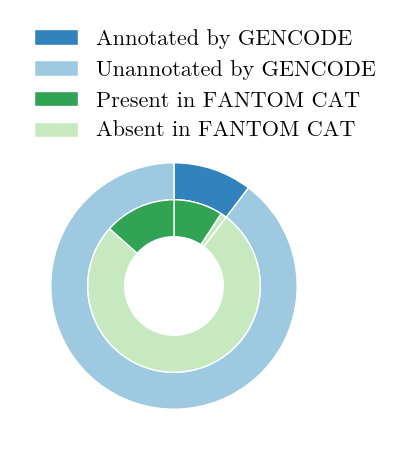

In [45]:
fig_fantom, ax = plt.subplots(figsize=(3,2))


cmap = plt.get_cmap("tab20c")
outer_colors = cmap([0,2])
inner_colors = cmap(np.array([8,11,11,8]))

patches_out, texts_out =ax.pie(annotation , radius=1, colors=outer_colors, counterclock=False, startangle=90,
      wedgeprops=dict(width=0.3, edgecolor='w'))

patches_in, texts_in = ax.pie(fantom, radius=0.7, colors=inner_colors, counterclock=False, startangle=90,
                             wedgeprops=dict(width=0.3, edgecolor='w'))
for w in patches_out:
    w.set_linewidth(0.5)
for w in patches_in:
    w.set_linewidth(0.5)

patches = patches_out + patches_in[0:2]
labels = ['Annotated by GENCODE','Unannotated by GENCODE', 'Present in FANTOM CAT', 'Absent in FANTOM CAT']
ax.legend(patches, labels, frameon=False, fontsize=8, loc=9, bbox_to_anchor=(0.6,1.4))
ax.set(aspect="equal")
plt.show()